## Race Predictions ##
### An exploration of data forcasting techniques so I don't forgot how data works in python ###

In [22]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#### Load Data ####

For the data, I will be using the  'jolpi.ca F1 API' which can be found [here](https://api.jolpi.ca/ergast/).

At first I played around with the idea of loading and structuing all the data myself, although this was far less performant and would require the split into testing and training data manually,
So instead I will be using Pandas.

For now, I have each race in a seperate DF but later I will combine them into a single dataframe with a race ID column for actual modelling. But this looks nicer for data visualisation for now

In [23]:
# Output data in pandas dataframe
base_url = "http://api.jolpi.ca/ergast/f1/2024/results"
limit = 100
offset = 0

response = requests.get(f"{base_url}?limit={1}&offset={offset}").json()
total_results = int(response["MRData"]["total"])
race_dataframes = {}

while offset < total_results:
    response = requests.get(f"{base_url}?limit={limit}&offset={offset}").json()
    results = response["MRData"]["RaceTable"]["Races"]

    for race in results:
        race_name = race["raceName"] 
        if race_name not in race_dataframes:
            race_dataframes[race_name] = []

        for res in race["Results"]:
            race_dataframes[race_name].append({
                "DriverCode": res["Driver"]["code"],
                "ConstructorId": res["Constructor"]["constructorId"],
                "StartingPosition": int(res["grid"]),
                "RaceResult": int(res["position"]),
                "PositionsGained": int(res["grid"]) - int(res["position"])
            })
    offset += limit

## In the next itteration of this model I will include other data like performance in the practices and things like lap times, but for now I will keep
## this as a simple benchmark
for race_name in race_dataframes:
    race_dataframes[race_name] = pd.DataFrame(race_dataframes[race_name])



print("Results for Bharain:")
print(race_dataframes["Bahrain Grand Prix"])


Results for Bharain:
   DriverCode ConstructorId  StartingPosition  RaceResult  PositionsGained
0         VER      red_bull                 1           1                0
1         PER      red_bull                 5           2                3
2         SAI       ferrari                 4           3                1
3         LEC       ferrari                 2           4               -2
4         RUS      mercedes                 3           5               -2
5         NOR       mclaren                 7           6                1
6         HAM      mercedes                 9           7                2
7         PIA       mclaren                 8           8                0
8         ALO  aston_martin                 6           9               -3
9         STR  aston_martin                12          10                2
10        ZHO        sauber                17          11                6
11        MAG          haas                15          12                3
12  

#### Basic Data Visualisation ####

Just to get a bit of a look at the data before we try some forcasting

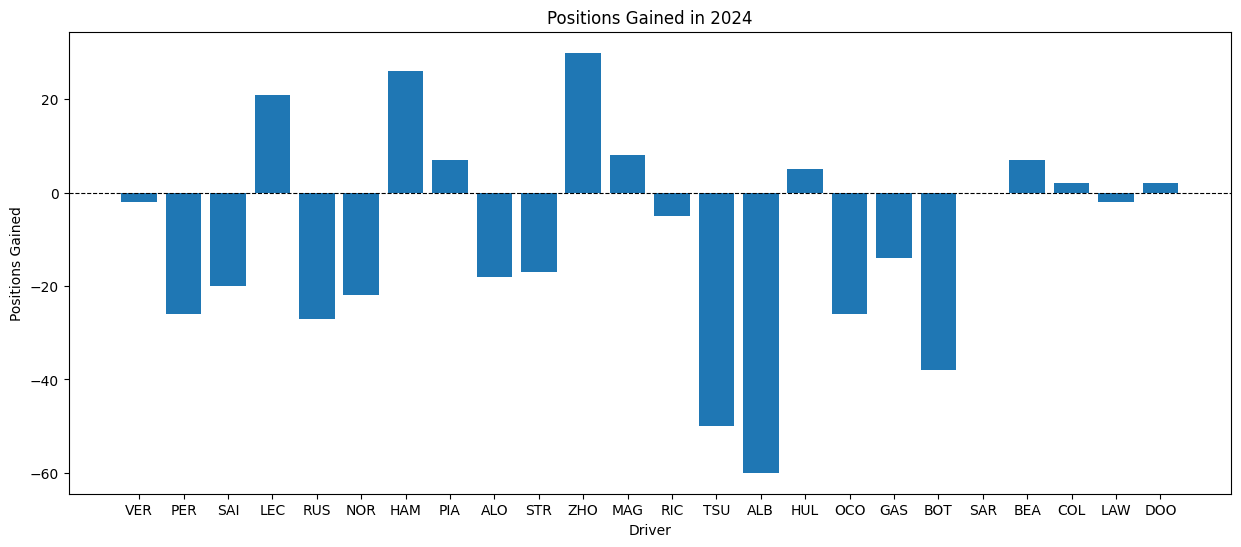

In [24]:
import matplotlib.pyplot as plt

# Total positions gained over the season
# Obviously insanely flawed because it doesn't take into account starting positions and includes anomaly like DNF
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Why does this look so negative?**

In terms of starting positions, there is not a number grid position for drivers who start in the pits, and the API returns it as 0. If the driver starts in position 0 then any result, even a 1st place, will be considered a negative result which hugely scew the results.

In order to fix this, we can just manually replace all these 0 values in the starting position with a heuristic calculated starting position. But what if there are multiple starting in the pits? Well there isn't really a way to know, so for now we will just assign this at random.

In [25]:
for race_name, df in race_dataframes.items():
    for index, row in df.iterrows(): 
        starting_pos = row["StartingPosition"]
        if starting_pos == 0:
            df.loc[index, "StartingPosition"] = df["StartingPosition"].max() + 1
    df["PositionsGained"] = df.apply(
        lambda row: int(row["StartingPosition"]) - int(row["RaceResult"]),
        axis=1
    )

print("Results for Bharain:")
print(race_dataframes["Bahrain Grand Prix"])

Results for Bharain:
   DriverCode ConstructorId  StartingPosition  RaceResult  PositionsGained
0         VER      red_bull                 1           1                0
1         PER      red_bull                 5           2                3
2         SAI       ferrari                 4           3                1
3         LEC       ferrari                 2           4               -2
4         RUS      mercedes                 3           5               -2
5         NOR       mclaren                 7           6                1
6         HAM      mercedes                 9           7                2
7         PIA       mclaren                 8           8                0
8         ALO  aston_martin                 6           9               -3
9         STR  aston_martin                12          10                2
10        ZHO        sauber                17          11                6
11        MAG          haas                15          12                3
12  

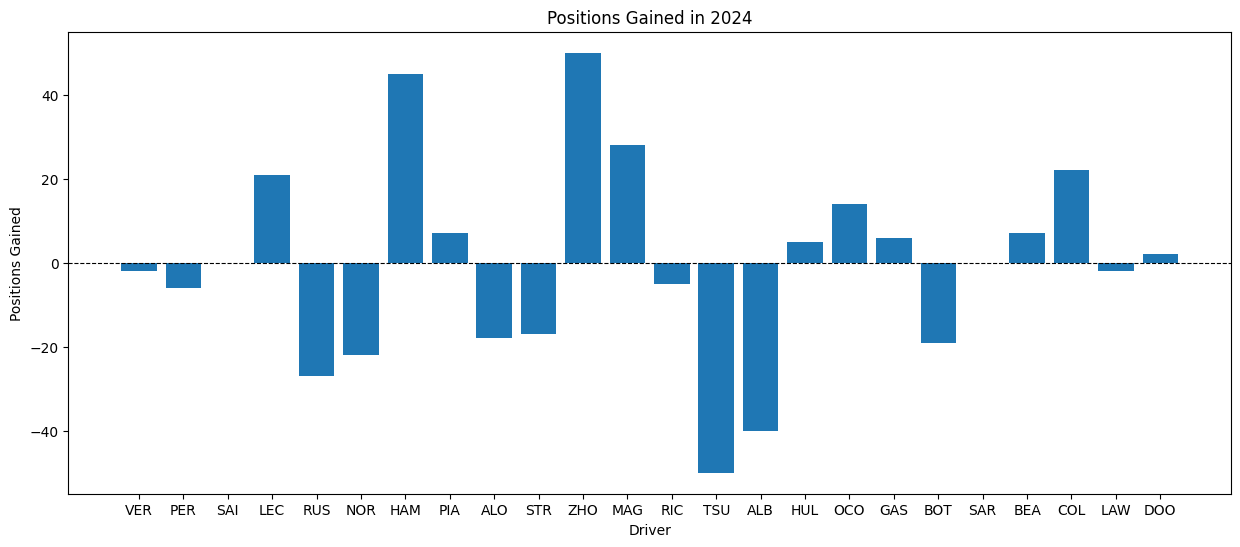

In [26]:
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

In [27]:
## Combine dataframe with a race ID
i = 1
for race_id, race_df in race_dataframes.items():
    race_df['RaceId'] = i  # Add a race identifier to each row
    i += 1

combined_df = pd.concat(race_dataframes.values(), ignore_index=True)
## In the next itteration of this model I will do feature engineering here to include things like constructor and driver average results to help the model
## but this this benchmark I will only use this.


# Convert categorical columns to numeric
le_driver = LabelEncoder()
le_constructor = LabelEncoder()

combined_df['DriverCode'] = le_driver.fit_transform(combined_df['DriverCode'])
combined_df['ConstructorId'] = le_constructor.fit_transform(combined_df['ConstructorId'])

# Split into features and targets
features = combined_df.drop(['RaceResult', 'PositionsGained'], axis=1)
targets = combined_df['RaceResult']  

print(features.head(5))
print(features.tail(5))

   DriverCode  ConstructorId  StartingPosition  RaceId
0          22              7                 1       1
1          14              7                 5       1
2          18              2                 4       1
3          10              2                 2       1
4          17              5                 3       1
     DriverCode  ConstructorId  StartingPosition  RaceId
474          11              3                14      24
475           9              6                12      24
476           3              8                 9      24
477           4              9                20      24
478          14              7                10      24


### Test train split ###
Given how important recent performance is on the races, doing the test train split on a race ofrecasting model is different to standard methods.
Again since this is just a V1 baseline of the model, I will use a simple test train split using a cut, but in the future itterations I will experiment with the impact of rolling windows

In [28]:
race_test_split = combined_df["RaceId"].max() - 4

test_split_mask = features["RaceId"] <= race_test_split

features_train = features[test_split_mask]
features_test = features[~test_split_mask]

targets_train = targets[test_split_mask]
targets_test = targets[~test_split_mask]

print(targets_test.tail(5))

474    16
475    17
476    18
477    19
478    20
Name: RaceResult, dtype: int64


##### Model Choices ####

There are so many models to choose from for prediction, but given the nature of the data and how the most recent are likely to be the most relevant on future performance, a forecasting model that takes this into account would be far superior. Obiviously I will test a number of different models across the future notebooks, but for now I will just implement a random forest. 

This isn't the most basic, but I think its safe to say linear regression and a normal decision tree would be so inneficient they're not worth considering.

In [29]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True)

classifier.fit(features_train, targets_train)

RandomForestClassifier(oob_score=True, random_state=0)

Accuracy: 11.25%
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.50      0.25      0.33         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.50      0.25      0.33         4
           6       0.50      0.50      0.50         4
           7       0.00      0.00      0.00         4
           8       0.25      0.25      0.25         4
           9       0.20      0.25      0.22         4
          10       0.25      0.25      0.25         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.50      0.25      0.33         4
          16       0.17      0.25      0.20         4
          17       0.00      0.00      0.00         4
          

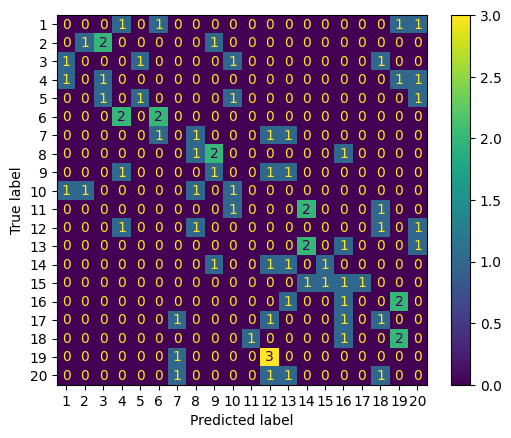

In [30]:
# perform the prediction using the random forest
# given all the corners cut and the fact this was a baseline, this is going to be a shockingly poor result

targets_predict = classifier.predict(features_test)

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

accuracy = accuracy_score(targets_test, targets_predict)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(targets_test, targets_predict))

ConfusionMatrixDisplay.from_estimator(classifier, features_test, targets_test)

#### Results ####

Unsurprising, this is shockingly bad

Of course this is just looking at all the classifications that are perfectly accurate, so lets take a slightly more useful hearistic in how far each prediction is away from the true output of the race.

In [31]:
import numpy as np
distances = np.abs(targets_test - targets_predict)
average_distance = np.mean(distances)
print(f"Average Distance from True Labels: {average_distance:.2f}")

Average Distance from True Labels: 4.50


An average output difference from 4.5 is actually not as terrible as first expected (in my personal opinion anyway)

Using the results, we can also predict things like predicting if each driver will gain or lose places and who will score points each weekend.

Another interesting statistic is comparing the difference in driver result to starting position with the prediction distance of the model